In [1]:
# Imports
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Função auxiliar para exibir imagens
def show(img, title='', cmap=None):
    plt.figure(figsize=(8,8))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [2]:
# Carregar modelo YOLO
model = YOLO('best.pt')

print("=" * 50)
print("INFORMAÇÕES DO MODELO")
print("=" * 50)
print(f"\nNomes das classes: {model.names}")
print(f"Número de classes: {len(model.names)}")
print(f"\nClasses detectáveis:")
for idx, name in model.names.items():
    print(f"  {idx}: {name}")
print("=" * 50)

INFORMAÇÕES DO MODELO

Nomes das classes: {0: 'brak', 1: 'good'}
Número de classes: 2

Classes detectáveis:
  0: brak
  1: good


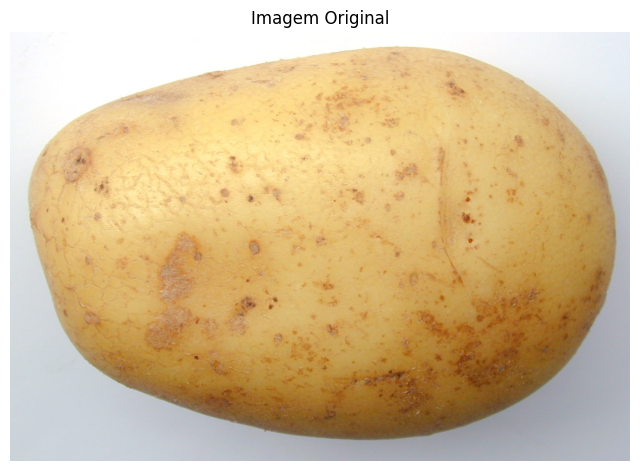

In [3]:
# Carregar imagem
img_path = 'dataset_batatas\\potato1.jpeg'
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError(f"Imagem não encontrada: {img_path}")

show(img, "Imagem Original")


0: 448x640 1 good, 84.5ms
Speed: 36.3ms preprocess, 84.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
0: 448x640 1 good, 84.5ms
Speed: 36.3ms preprocess, 84.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


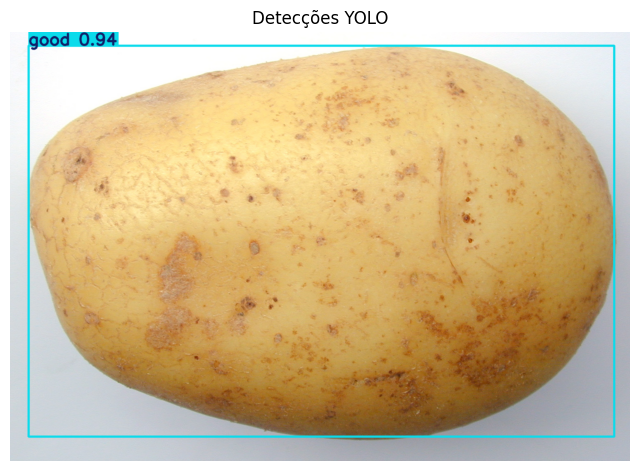


Detectou 1 batata(s):

Batata 1:
  Classe: good
  Confiança: 94.39%
  Coordenadas: x1=45, y1=33, x2=1475, y2=987


In [4]:
# Executar detecção YOLO
results = model(img)

# Processar resultados
for r in results:
    annotated = r.plot()
    show(annotated, "Detecções YOLO")
    
    print(f"\nDetectou {len(r.boxes)} batata(s):")
    
    for i, box in enumerate(r.boxes):
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        xyxy = box.xyxy[0].cpu().numpy()
        
        print(f"\nBatata {i+1}:")
        print(f"  Classe: {r.names[cls]}")
        print(f"  Confiança: {conf:.2%}")
        print(f"  Coordenadas: x1={int(xyxy[0])}, y1={int(xyxy[1])}, x2={int(xyxy[2])}, y2={int(xyxy[3])}")

## Pré-processamento e Segmentação

1. Pré-processamento...


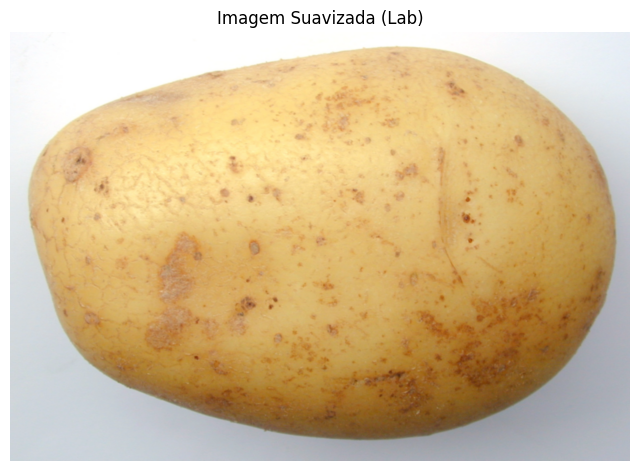

In [5]:
# Pré-processamento
print("1. Pré-processamento...")
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
blur = cv2.GaussianBlur(img_lab, (5,5), 0)

show(cv2.cvtColor(blur, cv2.COLOR_LAB2BGR), "Imagem Suavizada (Lab)")

2. Segmentação...


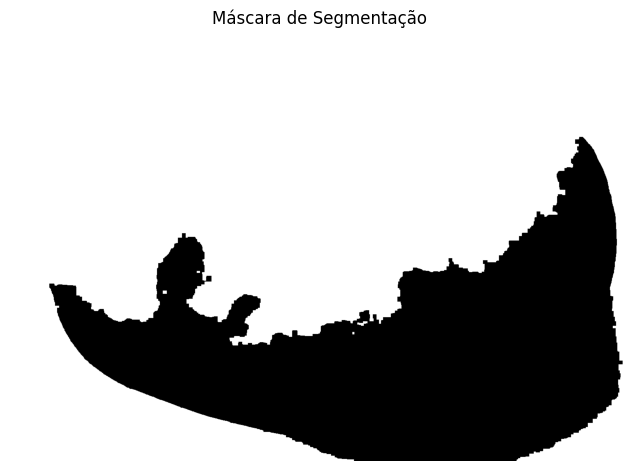

In [6]:
# Segmentação
print("2. Segmentação...")
L, A, B = cv2.split(blur)
_, mask = cv2.threshold(L, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

contours, hierarchy = cv2.findContours(mask_clean, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = mask_clean.copy()
for i in range(len(contours)):
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(mask_filled, [contours[i]], -1, 255, -1)

mask = mask_filled
show(mask, "Máscara de Segmentação")

## Análise de Defeitos - Distância de Mahalanobis

In [7]:
# Calcular média e covariância da região saudável
print("3. Calculando média e covariância...")
pixels = blur[mask == 255].reshape(-1, 3)
mean = np.mean(pixels, axis=0)
cov = np.cov(pixels, rowvar=False)
inv_cov = np.linalg.inv(cov)

print(f"Média (Lab): {mean}")
print(f"\nCovariância:\n{cov}")

3. Calculando média e covariância...
Média (Lab): [     213.12      130.63      151.69]

Covariância:
[[     487.82     -49.398     -210.93]
 [    -49.398      11.941      47.898]
 [    -210.93      47.898      405.85]]


4. Calculando distância de Mahalanobis...


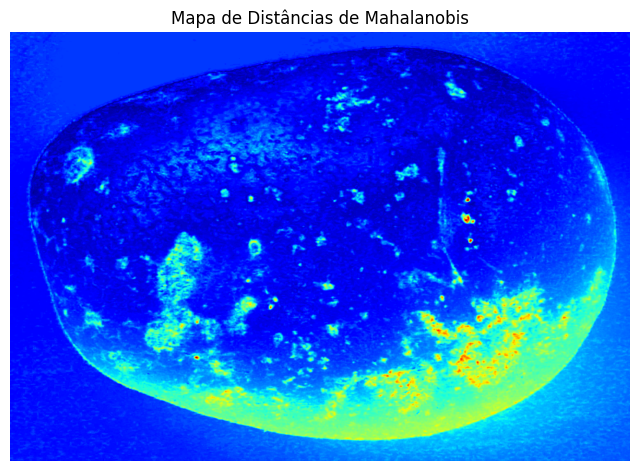

In [8]:
# Calcular distância de Mahalanobis
print("4. Calculando distância de Mahalanobis...")
h, w, c = blur.shape
diff = blur.reshape(-1, 3) - mean
mdist = np.sqrt(np.einsum('ij,jk,ik->i', diff, inv_cov, diff))
mdist_img = mdist.reshape(h, w)
mdist_norm = cv2.normalize(mdist_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

show(mdist_norm, "Mapa de Distâncias de Mahalanobis", cmap='jet')

5. Detectando regiões de defeitos...


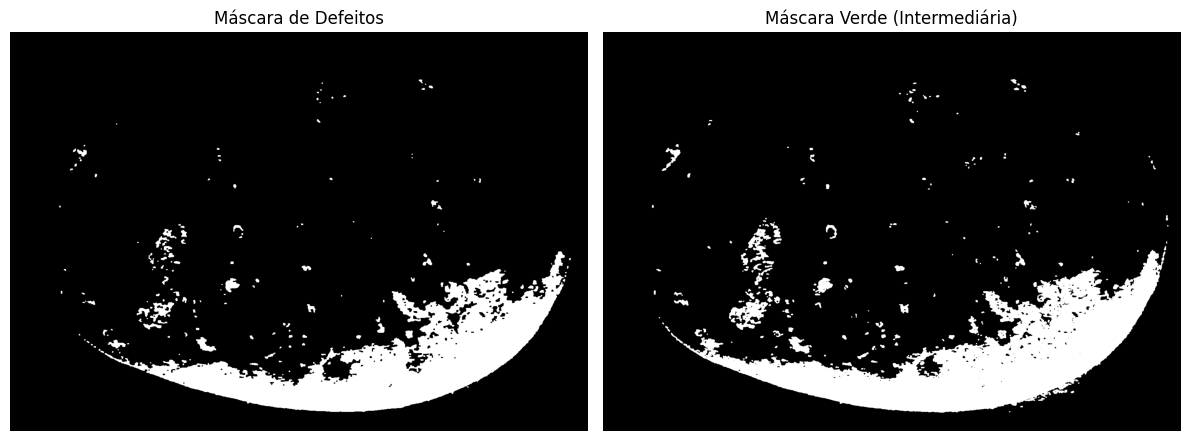

In [9]:
# Detecção de defeitos
print("5. Detectando regiões de defeitos...")
_, exclude_mask = cv2.threshold(mdist_norm, 180, 255, cv2.THRESH_BINARY)
_, defect_mask = cv2.threshold(mdist_norm, 100, 255, cv2.THRESH_BINARY)
defect_mask = cv2.bitwise_and(defect_mask, cv2.bitwise_not(exclude_mask))

kernel_defect = np.ones((3,3), np.uint8)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, kernel_defect)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_CLOSE, kernel_defect)

# Máscara verde (região intermediária)
lower = 90
upper = 180
green_mask = cv2.inRange(mdist_norm, lower, upper)
green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel_defect)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(defect_mask, cmap='gray')
axes[0].set_title('Máscara de Defeitos')
axes[0].axis('off')
axes[1].imshow(green_mask, cmap='gray')
axes[1].set_title('Máscara Verde (Intermediária)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Filtrar Defeitos por Detecções YOLO

6. Criando máscara das detecções YOLO...


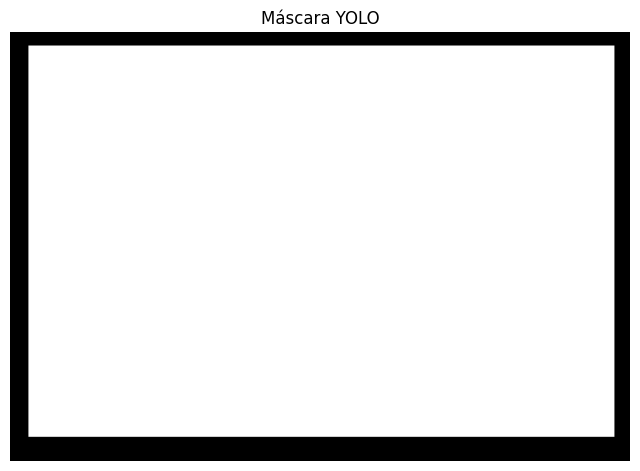

In [10]:
# Criar máscara de detecções YOLO
print("6. Criando máscara das detecções YOLO...")
yolo_mask = np.zeros(img.shape[:2], dtype=np.uint8)
for r in results:
    for box in r.boxes:
        xyxy = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, xyxy)
        cv2.rectangle(yolo_mask, (x1, y1), (x2, y2), 255, -1)

show(yolo_mask, "Máscara YOLO")

7. Filtrando defeitos dentro das batatas detectadas...


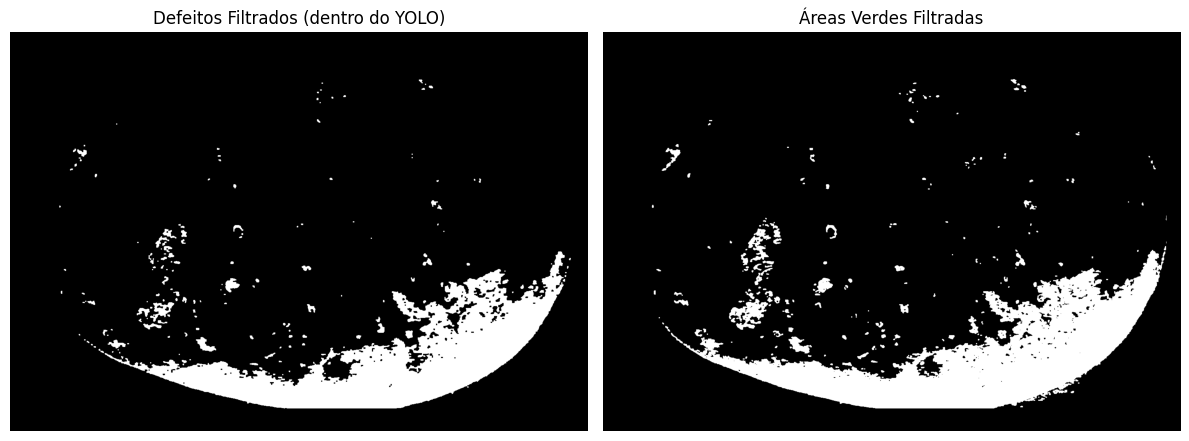

In [11]:
# Filtrar defeitos apenas dentro das detecções YOLO
print("7. Filtrando defeitos dentro das batatas detectadas...")
defect_mask_filtered = cv2.bitwise_and(defect_mask, yolo_mask)
green_mask_filtered = cv2.bitwise_and(green_mask, yolo_mask)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(defect_mask_filtered, cmap='gray')
axes[0].set_title('Defeitos Filtrados (dentro do YOLO)')
axes[0].axis('off')
axes[1].imshow(green_mask_filtered, cmap='gray')
axes[1].set_title('Áreas Verdes Filtradas')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Contagem de Defeitos por Batata

In [12]:
# Contar defeitos por batata detectada
print("\nAnalisando defeitos por batata:")
total_defects = 0

for r in results:
    for idx, box in enumerate(r.boxes):
        xyxy = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, xyxy)
        
        # Criar máscara apenas desta batata
        single_potato_mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.rectangle(single_potato_mask, (x1, y1), (x2, y2), 255, -1)
        
        # Extrair defeitos apenas dentro desta batata
        defects_in_potato = cv2.bitwise_and(defect_mask, single_potato_mask)
        
        # Contar componentes conectados (defeitos individuais)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(defects_in_potato, connectivity=8)
        
        defect_count = 0
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= 50:  # Área mínima
                defect_count += 1
        
        total_defects += defect_count
        
        # Calcular porcentagem de área com defeito nesta batata
        potato_area_single = (x2 - x1) * (y2 - y1)
        defect_area_single = np.sum(defects_in_potato == 255)
        percent_defect_single = (defect_area_single / potato_area_single) * 100 if potato_area_single > 0 else 0
        
        print(f"\nBatata {idx+1}:")
        print(f"  Defeitos: {defect_count}")
        print(f"  Área com defeito: {percent_defect_single:.2f}%")

print(f"\n✓ Total de defeitos detectados em todas as batatas: {total_defects}")

# Calcular porcentagem de área com defeito (geral)
defect_area = np.sum(defect_mask_filtered == 255)
potato_area = np.sum(yolo_mask == 255)
if potato_area > 0:
    percent_defect = (defect_area / potato_area) * 100
    print(f"✓ Porcentagem da área com defeito (geral): {percent_defect:.2f}%")


Analisando defeitos por batata:

Batata 1:
  Defeitos: 61
  Área com defeito: 11.20%

✓ Total de defeitos detectados em todas as batatas: 61
✓ Porcentagem da área com defeito (geral): 11.18%


## Visualização Final

8. Gerando visualização final...


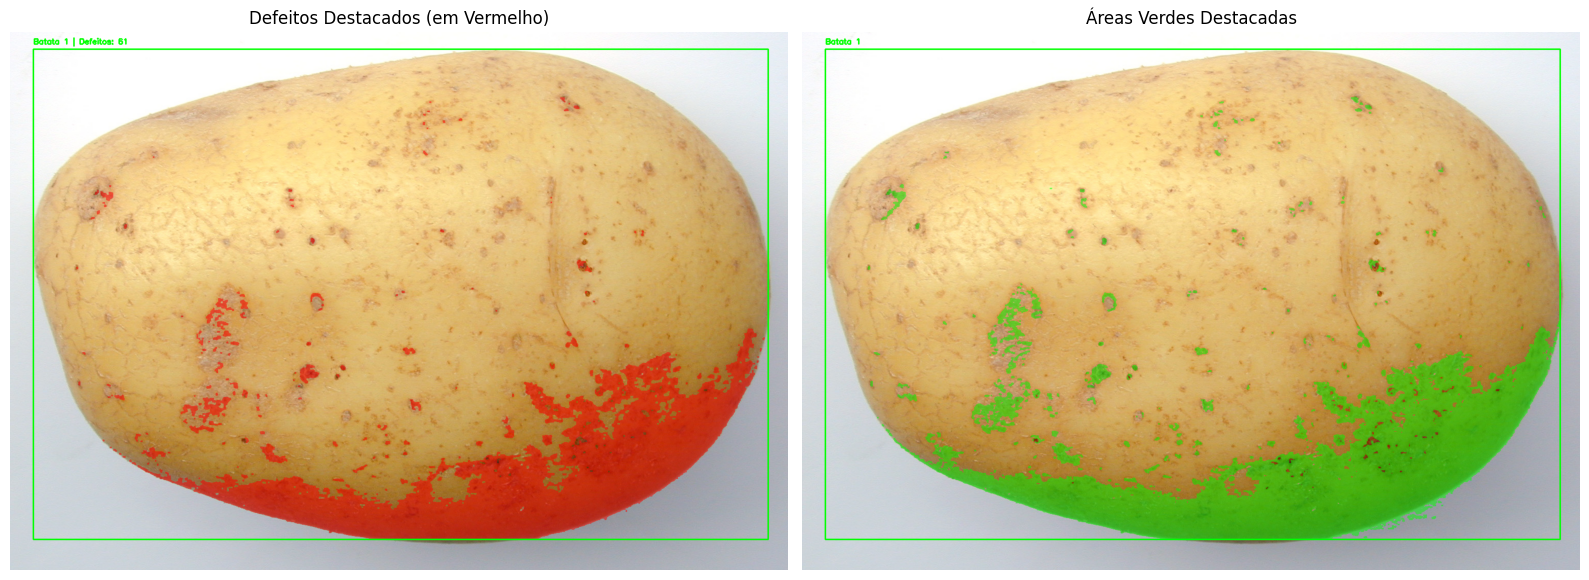

In [13]:
# Gerar visualização final
print("8. Gerando visualização final...")

# Overlay com defeitos em vermelho
overlay = img.copy()
overlay[defect_mask_filtered == 255] = [0, 0, 255]

# Overlay com áreas verdes
overlay_green = img.copy()
overlay_green[green_mask_filtered == 255] = [0, 255, 0]

alpha = 0.5
result = cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)
result_green = cv2.addWeighted(img, 1 - alpha, overlay_green, alpha, 0)

# Adicionar bounding boxes do YOLO com contagem de defeitos
for r in results:
    for idx, box in enumerate(r.boxes):
        xyxy = box.xyxy[0].cpu().numpy()
        x1, y1, x2, y2 = map(int, xyxy)
        conf = float(box.conf[0])
        
        # Contar defeitos nesta batata para o label
        single_potato_mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.rectangle(single_potato_mask, (x1, y1), (x2, y2), 255, -1)
        defects_in_potato = cv2.bitwise_and(defect_mask_filtered, single_potato_mask)
        num_labels_potato, _, stats_potato, _ = cv2.connectedComponentsWithStats(defects_in_potato, connectivity=8)
        defect_count = sum(1 for i in range(1, num_labels_potato) if stats_potato[i, cv2.CC_STAT_AREA] >= 50)
        
        cv2.rectangle(result, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.rectangle(result_green, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(result, f'Batata {idx+1} | Defeitos: {defect_count}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(result_green, f'Batata {idx+1}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axes[0].set_title('Defeitos Destacados (em Vermelho)')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(result_green, cv2.COLOR_BGR2RGB))
axes[1].set_title('Áreas Verdes Destacadas')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Salvar resultados
cv2.imwrite('resultado_defeitos.jpg', result)
cv2.imwrite('resultado_defeitos_verdes.jpg', result_green)
cv2.imwrite('mascara_defeitos.jpg', defect_mask_filtered)
cv2.imwrite('mascara_verde.jpg', green_mask_filtered)
cv2.imwrite('mapa_mahalanobis.jpg', mdist_norm)

print("\n✓ Imagens salvas:")
print("  - resultado_defeitos.jpg (defeitos em vermelho + bounding boxes)")
print("  - resultado_defeitos_verdes.jpg (áreas verdes + bounding boxes)")
print("  - mascara_defeitos.jpg (máscara binária dos defeitos)")
print("  - mascara_verde.jpg (máscara binária das áreas verdes)")
print("  - mapa_mahalanobis.jpg (mapa de calor)")
print("\n" + "=" * 50)
print("PROCESSAMENTO CONCLUÍDO")
print("=" * 50)